In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
import datetime

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_budgets/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [5]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing numbe

### Subselect time period

### Calculate section transports

In [6]:
# Volumetric transport (m^3/s)
x_vol = main['UVELMASS'] * main['drF'] * main['dyG'] 
y_vol = main['VVELMASS'] * main['drF'] * main['dxG'] 

# Salt transport (psu.m^3/s)
x_slt = main['ADVx_SLT'] + main['DFxE_SLT']
y_slt = main['ADVy_SLT'] + main['DFyE_SLT']

In [7]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [8]:
sections = ['Davis Strait', 'Denmark Strait', 'Iceland Faroe', 'Faroe Scotland', 'Scotland Norway',
            'Fram Strait','Barents Sea','Labrador Greenland', 'Hudson Strait','English Channel',
            'Newfoundland Iberia','Bering Strait']

vol_trsp = []
slt_trsp = []

for name in sections:
    print(name)
    pt1,pt2 = ecco.get_section_endpoints(name)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

    # Volume transports (Sv)
    sec_trsp_x = (x_vol * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_vol * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    vol_trsp.append(sec_trsp*Sv)
    
    # Salt transport (psu Sv)
    sec_trsp_x = (x_slt * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_slt * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    slt_trsp.append(sec_trsp*Sv)

Davis Strait
Denmark Strait
Iceland Faroe
Faroe Scotland
Scotland Norway
Fram Strait
Barents Sea
Labrador Greenland
Hudson Strait
English Channel
Newfoundland Iberia
Bering Strait


In [9]:
vol_trsp = xr.concat(vol_trsp,pd.Index(sections, name='section'))
slt_trsp = xr.concat(slt_trsp,pd.Index(sections, name='section'))

In [10]:
ds = vol_trsp.to_dataset(name='vol')
ds['salt'] = slt_trsp

In [11]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_section_transports_slt.nc', format='NETCDF4')
#ds.to_netcdf('/mnt/efs/data/ecco/ecco_section_transports_slt_adv.nc', format='NETCDF4')

In [12]:
ds.sel(time=slice('1993-01-01','2015-12-31')).mean('time').to_dataframe()

,vol,salt
section,,
Davis Strait,-1.546748,-50.716587
Denmark Strait,-5.421835,-186.658191
Iceland Faroe,3.600647,126.857354
Faroe Scotland,2.120963,75.202758
Scotland Norway,0.070590,2.171717
Fram Strait,-2.896728,-99.328460
Barents Sea,3.327009,116.872436
Labrador Greenland,-1.603133,-50.727929
Hudson Strait,-0.029700,-0.032179


,vol,salt
section,,
Davis Strait,-1.546748,-50.808457
Denmark Strait,-5.421835,-187.462650
Iceland Faroe,3.600647,126.760406
Faroe Scotland,2.120963,75.196674
Scotland Norway,0.070590,2.184652
Fram Strait,-2.896728,-99.346069
Barents Sea,3.327009,116.817166
Labrador Greenland,-1.603133,-50.712581
Hudson Strait,-0.029700,-0.031325


In [13]:
vol_trsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_slt.nc').vol
slt_trsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_slt.nc').salt

## Define the section lines 

In [14]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [15]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [16]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [17]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

In [18]:
terms = ['tendV', 'forcV', 'ConvV', 'totalV']

budg_volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Volume tendency (m^3/s)
    tendV = (budg_vol.tendV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sea surface forcing on volume (m^3/s)
    forcV = (budg_vol.forcV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of volume transport (m^3/s)
    ConvV = ((budg_vol.hConvV+budg_vol.vConvV)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalV = ConvV + forcV
    
    results = dask.compute(tendV*Sv, forcV*Sv, ConvV*Sv, totalV*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_volume.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [19]:
region = ['spna', 'nsea', 'lsea']
budg_volume = xr.concat(budg_volume,pd.Index(region, name='region'))

#### Save to netcdf

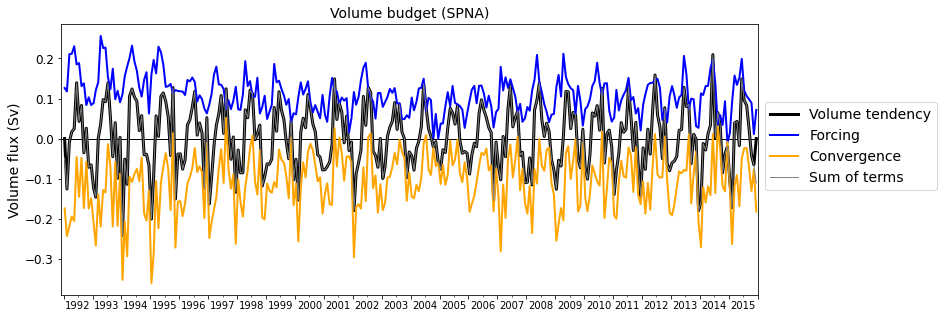

In [22]:

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Volume budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [23]:
ConvV_spna_bnd = vol_trsp.sel(section='Newfoundland Iberia') + vol_trsp.sel(section='English Channel') \
                    - vol_trsp.sel(section='Hudson Strait') - vol_trsp.sel(section='Davis Strait') \
                    - vol_trsp.sel(section='Denmark Strait') - vol_trsp.sel(section='Iceland Faroe') \
                    - vol_trsp.sel(section='Faroe Scotland')

In [24]:
ConvV_nsea_bnd = vol_trsp.sel(section='Denmark Strait') + vol_trsp.sel(section='Iceland Faroe') \
                    + vol_trsp.sel(section='Faroe Scotland') + vol_trsp.sel(section='Scotland Norway') \
                    - vol_trsp.sel(section='Fram Strait') - vol_trsp.sel(section='Barents Sea')

In [25]:
ConvV_lsea_bnd = vol_trsp.sel(section='Labrador Greenland') - vol_trsp.sel(section='Hudson Strait') \
                    - vol_trsp.sel(section='Davis Strait')

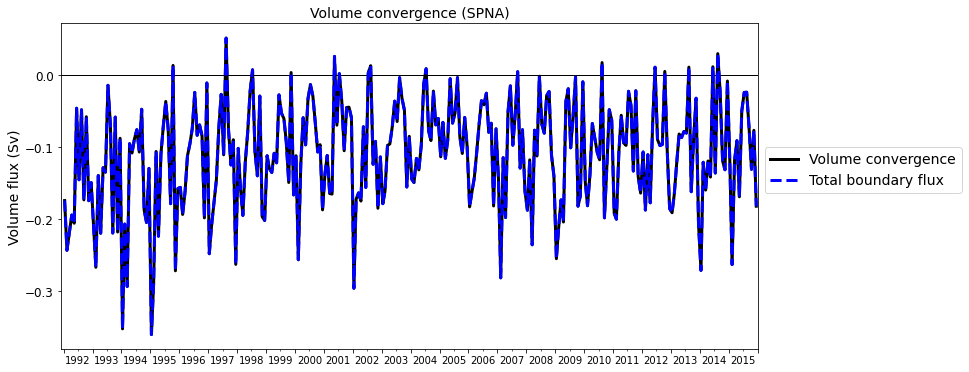

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_spna_bnd.time, ConvV_spna_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

### Salt budget

In [28]:
terms = ['tendS', 'forcS', 'adv_ConvS', 'dif_ConvS', 'ConvS', 'totalS', 'salt']

budg_slt = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Temperature tendency (psu m^3/s)
    tendS = (budg_vol.tendS*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Forcing (psu m^3/s)
    forcS = (budg_vol.forcS*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Advection (psu m^3/s)
    adv_ConvS = ((budg_vol.adv_hConvS+budg_vol.adv_vConvS)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Diffusion (psu m^3/s)
    dif_ConvS = ((budg_vol.dif_hConvS+budg_vol.dif_vConvS)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Total convergence (psu m^3/s)
    ConvS = adv_ConvS + dif_ConvS
    
    # Sum of terms (psu m^3/s)
    totalS = ConvS + forcS
    
    # Salt content (psu m^3)
    salt = ((main.SALT*vol)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    results = dask.compute(tendS.reset_coords(drop=True)*Sv, forcS.reset_coords(drop=True)*Sv, 
                           adv_ConvS.reset_coords(drop=True)*Sv, dif_ConvS.reset_coords(drop=True)*Sv, 
                           ConvS.reset_coords(drop=True)*Sv, totalS.reset_coords(drop=True)*Sv,
                           salt.reset_coords(drop=True))
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_slt.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [29]:
region = ['spna', 'nsea', 'lsea']
budg_slt = xr.concat(budg_slt,pd.Index(region, name='region'))

#### Save to netcdf

In [30]:
ds = budg_slt.reset_coords(drop=True).to_dataset(name='budg_salt')

In [31]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_slt.nc', format='NETCDF4')

In [14]:
budg_slt = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_slt.nc').budg_salt

### Plots

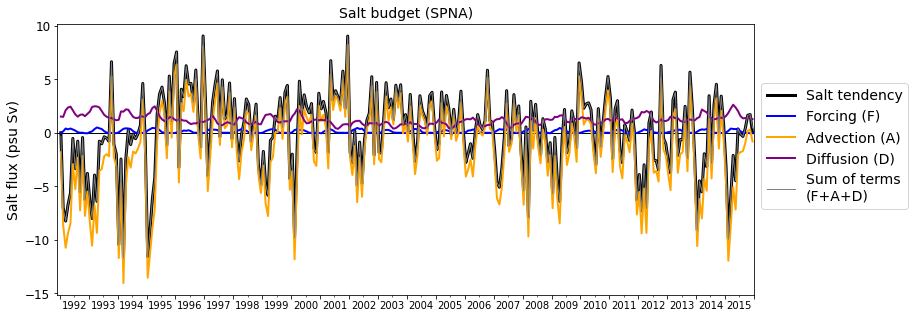

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Salt budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='tendS'), lw=3, color='black',label='Salt tendency')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='forcS'), lw=2, color='blue',label='Forcing (F)')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='adv_ConvS'), lw=2, color='orange',label='Advection (A)')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='dif_ConvS'), lw=2, color='purple',label='Diffusion (D)')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='totalS'), lw=1, color='grey',
        label='Sum of terms\n(F+A+D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

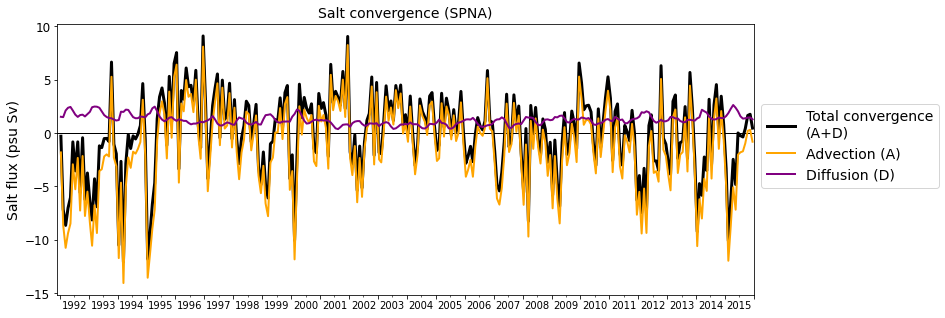

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Salt convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='ConvS'), lw=3, color='k', label='Total convergence\n(A+D)')

ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='adv_ConvS'), lw=2, color='orange', label='Advection (A)')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='dif_ConvS'), lw=2, color='purple', label='Diffusion (D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*


In [15]:
ConvS_spna_bnd = slt_trsp.sel(section='Newfoundland Iberia') + slt_trsp.sel(section='English Channel') \
                    - slt_trsp.sel(section='Hudson Strait') - slt_trsp.sel(section='Davis Strait') \
                    - slt_trsp.sel(section='Denmark Strait') - slt_trsp.sel(section='Iceland Faroe') \
                    - slt_trsp.sel(section='Faroe Scotland')

In [16]:
ConvS_nsea_bnd = slt_trsp.sel(section='Denmark Strait') + slt_trsp.sel(section='Iceland Faroe') \
                    + slt_trsp.sel(section='Faroe Scotland') + slt_trsp.sel(section='Scotland Norway') \
                    - slt_trsp.sel(section='Fram Strait') - slt_trsp.sel(section='Barents Sea')

In [17]:
ConvS_lsea_bnd = slt_trsp.sel(section='Labrador Greenland') - slt_trsp.sel(section='Hudson Strait') \
                    - slt_trsp.sel(section='Davis Strait')

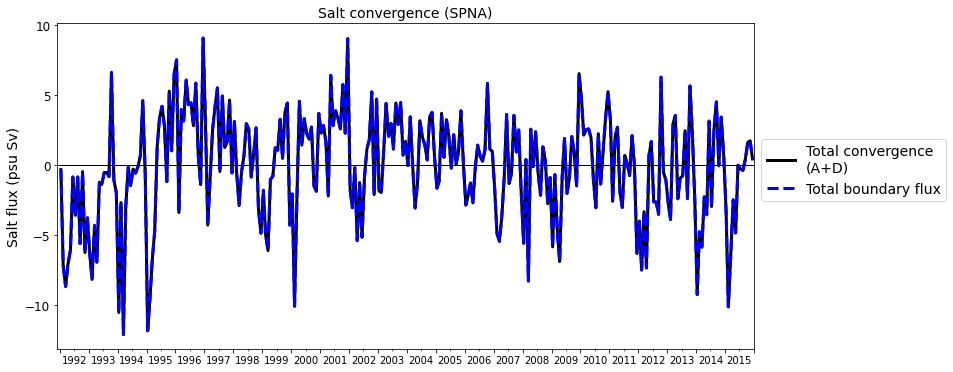

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salt convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='ConvS'), lw=3, color='k', label='Total convergence\n(A+D)')
ax.plot(ConvS_spna_bnd.time, ConvS_spna_bnd, lw=3, color='b', ls='--', label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

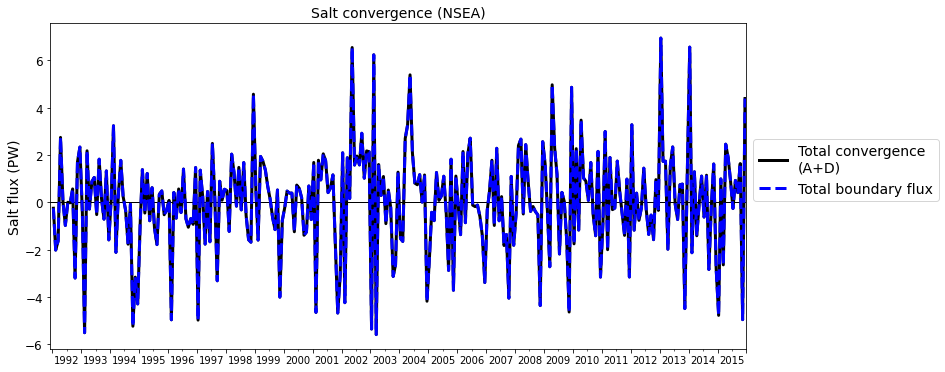

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salt convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time,budg_slt.sel(region='nsea',term='ConvS'), lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvS_nsea_bnd.time, ConvS_nsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

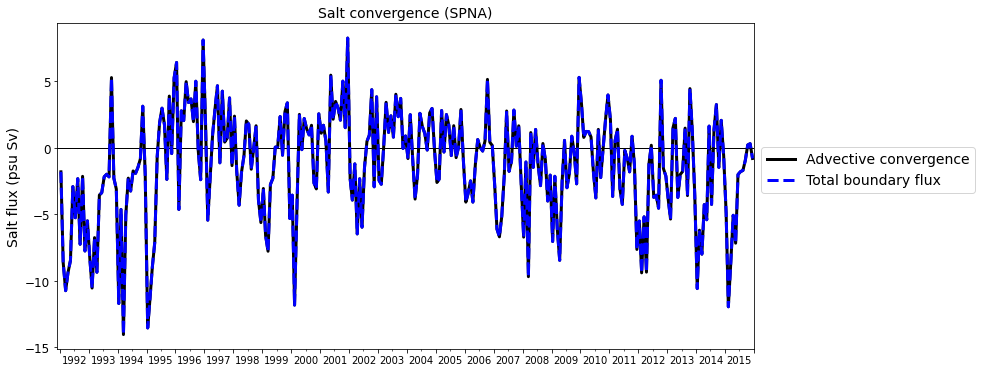

In [42]:
# ecco_section_transports_adv_slt
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salt convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time, budg_slt.sel(region='spna',term='adv_ConvS'), lw=3, color='k', label='Advective convergence')
ax.plot(ConvS_spna_bnd.time, ConvS_spna_bnd, lw=3, color='b', ls='--', label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

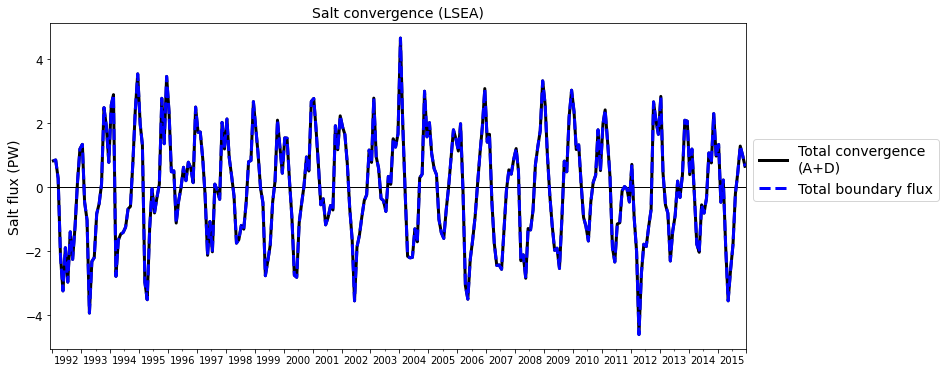

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salt convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_slt.time,budg_slt.sel(region='lsea',term='ConvS'), lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvS_lsea_bnd.time, ConvS_lsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salt flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()